
[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
📡 Fetching COVID-19 data from Johns Hopkins...
✅ Confirmed data loaded: 289 rows
✅ Deaths data loaded: 289 rows
✅ Recovered data loaded: 274 rows

✅ Cleaned data: 229,743 records from 2020-01-22 → 2023-03-09


Dropdown(description='Country:', index=80, options=('Afghanistan', 'Albania', 'Algeria', 'Andorra', 'Angola', …

interactive(children=(Dropdown(description='Country:', index=80, options=('Afghanistan', 'Albania', 'Algeria',…


🌎 Preparing top-10 countries by total confirmed cases...


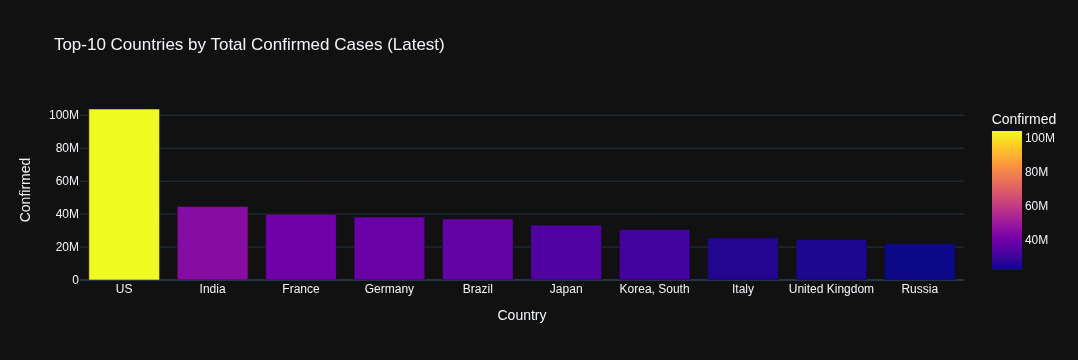

In [2]:
# ===============================================================
# 🌍 Advanced COVID-19 Data Dashboard (2025-Compatible)
# ===============================================================

!pip install pandas matplotlib plotly requests ipywidgets -q

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import requests
from datetime import datetime, timedelta
from IPython.display import display, HTML
import ipywidgets as widgets

plt.style.use('ggplot')

# ---------------------------------------------------------------
# 1️⃣ Fetch Data from Johns Hopkins GitHub
# ---------------------------------------------------------------
print("📡 Fetching COVID-19 data from Johns Hopkins...")

URL_BASE = "https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/" \
            "csse_covid_19_time_series/"

files = {
    "confirmed": "time_series_covid19_confirmed_global.csv",
    "deaths": "time_series_covid19_deaths_global.csv",
    "recovered": "time_series_covid19_recovered_global.csv"
}

dfs = {}
for key, fname in files.items():
    url = URL_BASE + fname
    try:
        df = pd.read_csv(url, on_bad_lines='skip')
        # Standardize column names
        df.columns = [c.strip() for c in df.columns]
        dfs[key] = df
        print(f"✅ {key.title()} data loaded: {len(df)} rows")
    except Exception as e:
        print(f"⚠️ Could not load {key} data: {e}")

# ---------------------------------------------------------------
# 2️⃣ Clean and Reshape Data
# ---------------------------------------------------------------
def reshape_covid(df, value_name):
    # Remove non-date columns safely
    id_cols = [c for c in df.columns if not c[0].isdigit()]
    value_cols = [c for c in df.columns if c not in id_cols]
    df = df.groupby("Country/Region", as_index=False)[value_cols].sum()
    df_melted = df.melt(id_vars=["Country/Region"], var_name="Date", value_name=value_name)
    # Handle date parsing robustly
    df_melted = df_melted[df_melted["Date"].str.match(r"\d{1,2}/\d{1,2}/\d{2}")]
    df_melted["Date"] = pd.to_datetime(df_melted["Date"], errors="coerce", format="%m/%d/%y")
    df_melted = df_melted.dropna(subset=["Date"])
    df_melted.rename(columns={"Country/Region": "Country"}, inplace=True)
    return df_melted

confirmed = reshape_covid(dfs["confirmed"], "Confirmed")
deaths = reshape_covid(dfs["deaths"], "Deaths")
recovered = reshape_covid(dfs["recovered"], "Recovered") if "recovered" in dfs else None

# Merge frames
covid = confirmed.merge(deaths, on=["Country", "Date"], how="outer")
if recovered is not None:
    covid = covid.merge(recovered, on=["Country", "Date"], how="left")
covid.fillna(0, inplace=True)

print(f"\n✅ Cleaned data: {len(covid):,} records from {covid['Date'].min().date()} → {covid['Date'].max().date()}")

# ---------------------------------------------------------------
# 3️⃣ Interactive Widgets
# ---------------------------------------------------------------
country_widget = widgets.Dropdown(
    options=sorted(covid['Country'].unique()),
    value='India' if 'India' in covid['Country'].unique() else covid['Country'].iloc[0],
    description='Country:'
)
display(country_widget)

# ---------------------------------------------------------------
# 4️⃣ Analysis and Visualization Function
# ---------------------------------------------------------------
def plot_country_analysis(country):
    data = covid[covid['Country'] == country].sort_values('Date').copy()
    data['New_Cases'] = data['Confirmed'].diff().fillna(0)
    data['New_Deaths'] = data['Deaths'].diff().fillna(0)
    data['7d_Avg_Cases'] = data['New_Cases'].rolling(7).mean()
    data['7d_Avg_Deaths'] = data['New_Deaths'].rolling(7).mean()
    data['Fatality_Rate'] = np.where(data['Confirmed'] > 0, (data['Deaths'] / data['Confirmed']) * 100, 0)

    # Summary
    latest = data.iloc[-1]
    print("\n=== COVID-19 Summary for", country, "===")
    print(f"Date: {latest['Date'].date()}")
    print(f"Total Confirmed: {int(latest['Confirmed']):,}")
    print(f"Total Deaths: {int(latest['Deaths']):,}")
    print(f"Fatality Rate: {latest['Fatality_Rate']:.2f}%")
    print(f"7-Day Avg New Cases: {int(latest['7d_Avg_Cases']):,}")
    print(f"7-Day Avg Deaths: {int(latest['7d_Avg_Deaths']):,}")

    # ----- Plot 1: Cumulative Cases & Deaths -----
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    axes[0].plot(data['Date'], data['Confirmed'], label='Total Cases', color='tab:blue')
    axes[0].plot(data['Date'], data['Deaths'], label='Total Deaths', color='tab:red')
    axes[0].set_title(f"{country} - Cumulative COVID-19 Cases & Deaths")
    axes[0].legend()

    # ----- Plot 2: Daily New Cases -----
    axes[1].bar(data['Date'], data['New_Cases'], color='skyblue', label='New Cases')
    axes[1].plot(data['Date'], data['7d_Avg_Cases'], color='navy', label='7-Day Avg')
    axes[1].set_title('Daily New Cases')
    axes[1].legend()

    # ----- Plot 3: Daily Deaths -----
    axes[2].bar(data['Date'], data['New_Deaths'], color='lightcoral', label='New Deaths')
    axes[2].plot(data['Date'], data['7d_Avg_Deaths'], color='darkred', label='7-Day Avg')
    axes[2].set_title('Daily Deaths')
    axes[2].legend()
    plt.tight_layout()
    plt.show()

    # ----- Plotly Interactive -----
    fig = px.line(data, x='Date', y=['Confirmed', 'Deaths'],
                  title=f"{country} COVID-19 Time Series",
                  labels={'value': 'Count', 'variable': 'Metric'},
                  template='plotly_dark')
    fig.show()

    # ----- Growth Rate -----
    data['Growth_Rate_%'] = data['Confirmed'].pct_change().replace([np.inf, np.nan], 0) * 100
    plt.figure(figsize=(10, 4))
    plt.plot(data['Date'], data['Growth_Rate_%'], color='teal')
    plt.title(f"{country} - Daily Growth Rate of Confirmed Cases (%)")
    plt.xlabel("Date")
    plt.ylabel("Growth Rate (%)")
    plt.grid(True)
    plt.show()

    # ----- Fatality Rate -----
    plt.figure(figsize=(10, 4))
    plt.plot(data['Date'], data['Fatality_Rate'], color='black')
    plt.title(f"{country} - Case Fatality Rate (%)")
    plt.xlabel("Date")
    plt.ylabel("Fatality Rate (%)")
    plt.grid(True)
    plt.show()

# ---------------------------------------------------------------
# 5️⃣ Connect Interactive Dropdown
# ---------------------------------------------------------------
widgets.interact(plot_country_analysis, country=country_widget);

# ---------------------------------------------------------------
# 6️⃣ Global Comparison
# ---------------------------------------------------------------
print("\n🌎 Preparing top-10 countries by total confirmed cases...")

top10 = covid.groupby('Country')['Confirmed'].max().nlargest(10).index.tolist()
top10_df = covid[covid['Country'].isin(top10)]
top10_latest = top10_df[top10_df['Date'] == top10_df['Date'].max()]

fig = px.bar(top10_latest.sort_values('Confirmed', ascending=False),
             x='Country', y='Confirmed',
             title='Top-10 Countries by Total Confirmed Cases (Latest)',
             color='Confirmed', template='plotly_dark')
fig.show()
